
## Constraints model

* link

## Web application (NOT deployed yet)

Run interactively on the web at: https://rcalix1.github.io/ProbabilityDensityFunctionsFromNeuralNets/experiments/2023/july2023/XGBoost/deployment/tuyere/




## Inputs



(2, 'i_h2i_rate')

(3, 'i_h2_temp')

(4, 'i_ngi_rate')

(6, 'i_pci_rate')

(11, 'i_o2_volfract')

(12, 'i_hbtemp')

(13, 'i_wind_rt')


## Outputs


* desired output requirements 

Raceway flame temp > 1900K.....(19, 'o_fta')
 
Hot metal temp > 1700K........(21, 'o_hmt')

Top gas temp > 100C,,,,,,,,,,,(23, 'o_tgt')








## Installs


In [1]:

## !pip install xgboost
## !pip install onnxmltools
## !pip install onnxruntime



## Imports


In [2]:

import torch
import numpy as np
import pandas as pd
import sklearn
import torch.nn as nn
import torch.nn.functional as F

import matplotlib.pyplot as plt
import math
import seaborn as sns
import random
import functorch


import torch.optim as optim


from numpy.random import normal
from scipy.stats import norm
import scipy.stats as stats
from numpy import hstack
from numpy import vstack
from numpy import exp
from sklearn.neighbors import KernelDensity

##from typing import Optional

from torch import Tensor


from torch.utils.data import TensorDataset, DataLoader

from mlxtend.plotting import heatmap

## coefficient of determination (R**2)
from sklearn.metrics import r2_score

np.set_printoptions(suppress=True)
torch.set_printoptions(sci_mode=False)




In [3]:

import xgboost as xgb
from xgboost import XGBClassifier, XGBRegressor, DMatrix, train as train_xgb
from sklearn.datasets import load_boston
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

import onnxmltools
from onnxmltools.convert.xgboost.operator_converters.XGBoost import (
    convert_xgboost)
from onnxmltools.convert import convert_xgboost as convert_xgboost_booster


from zipfile import ZipFile
from skl2onnx.common.data_types import FloatTensorType
from skl2onnx import convert_sklearn, to_onnx, update_registered_converter
from skl2onnx.common.shape_calculator import (
    calculate_linear_classifier_output_shapes,
    calculate_linear_regressor_output_shapes)


# Import the ONNX runtime environment
import onnxruntime as rt



/Users/user/opt/anaconda3/envs/CIVS_py37/lib/python3.7/site-packages/skl2onnx/algebra/onnx_ops.py:159: UserWarning: OpSchema.FormalParameter.typeStr is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.type_str instead.
  tys = obj.typeStr or ''
/Users/user/opt/anaconda3/envs/CIVS_py37/lib/python3.7/site-packages/skl2onnx/algebra/automation.py:154: UserWarning: OpSchema.FormalParameter.isHomogeneous is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.is_homogeneous instead.
  if getattr(obj, 'isHomogeneous', False):
/Users/user/opt/anaconda3/envs/CIVS_py37/lib/python3.7/site-packages/jinja2/environment.py:485: UserWarning: OpSchema.FormalParameter.typeStr is deprecated and will be removed in 1.16. Use OpSchema.FormalParameter.type_str instead.
  return getattr(obj, attribute)


In [4]:

import PDFshapingUtils as PDF_tk



## Instantiate PDF shaping and regression class


In [5]:

PDFshapingOBJ = PDF_tk.PDFshapingUtils()



## Initialize parameters


In [6]:

PDFshapingOBJ.N_error_range = 5         ## 20
PDFshapingOBJ.mean_impulse  = 0.0       ## -7.0      ## 0.0
PDFshapingOBJ.std_impulse   = 0.001     ## 1.0
PDFshapingOBJ.kde_std       = 0.5       ## 0.1       ## 0.5      ## 3.0  ## smaller is better approximation?
PDFshapingOBJ.bandwidth     = 0.2       ## 0.2->more jagged, 2.0->more smooth


In [7]:

PDFshapingOBJ.initializeImpulseGaussian()



## Run checks


In [8]:

## print(PDFshapingOBJ.x_range_impulse_func )
## print(PDFshapingOBJ.impulse_func_vector_vals )
## print(PDFshapingOBJ.quadratic_weights)
## print(PDFshapingOBJ.x_range_impulse_func.shape )
## print(PDFshapingOBJ.impulse_func_vector_vals.shape )
## print(PDFshapingOBJ.quadratic_weights.shape)
 
## print( sum(PDFshapingOBJ.impulse_func_vector_vals) )      ## should add up to 100 (i.e. 1.0 prob density)


In [9]:

## plt.plot(PDFshapingOBJ.x_range_impulse_func, PDFshapingOBJ.impulse_func_vector_vals)
## plt.show()



## RUN KDE test


In [10]:

## PDFshapingOBJ.test_torchKDE_with_fake_data()



## Load Data


In [11]:

PDFshapingOBJ.read_csv_file_with_pandas('CFD.14.2025_REVISED.csv')


In [12]:

PDFshapingOBJ.CFD_raw_data


,Index,Case_Name,i_h2i_rate,i_h2_temp,i_ngi_rate,i_ng_temp,i_pci_rate,i_wpi_rate,i_sgi_rate,i_sgi_COH2ratio,...,o_co2_sollos,o_h2o_sollos,o_feo_sollos,o_hm_rt,o_mw_rt,o_wf_rt,o_hm_h2share,o_mw_h2share,o_wf_h2share,o_prod_rt
0,1,H2-10_PCI-0_WPI-0_NG-0_O2-30_NGT-0_H2T-1200_HB...,10,1200,0,0,0,0,0,0,...,27.5,9.08,53.42225,188.0,407.0,1090.0,13.3,12.3,34.2,6230.0
1,2,H2-10_PCI-0_WPI-0_NG-0_O2-30_NGT-0_H2T-600_HBT...,10,600,0,0,0,0,0,0,...,28.3,9.23,51.71010,188.0,407.0,1100.0,13.2,12.2,34.1,6250.0
2,3,H2-10_PCI-0_WPI-0_NG-0_O2-30_NGT-0_H2T-300_HBT...,10,300,0,0,0,0,0,0,...,25.9,8.47,54.11249,188.0,407.0,1110.0,13.1,12.2,34.9,6250.0
3,4,H2-20_PCI-0_WPI-0_NG-0_O2-30_NGT-0_H2T-1200_HB...,20,1200,0,0,0,0,0,0,...,25.4,14.80,44.36503,206.0,446.0,1210.0,21.0,18.3,44.7,6840.0
4,5,H2-10_PCI-0_WPI-0_NG-0_O2-30_NGT-0_H2T-600_HBT...,10,600,0,0,0,0,0,0,...,25.9,8.46,56.56291,186.0,403.0,1090.0,13.3,12.1,34.7,6190.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
946,947,H2-0_PCI-0_WPI-0_NG-100_O2-21_NGT-300_H2T-0_HB...,0,0,100,300,0,0,0,0,...,20.9,19.20,52.23245,124.0,268.0,690.0,27.7,23.2,60.6,4090.0
947,948,H2-0_PCI-0_WPI-0_NG-60_O2-21_NGT-300_H2T-0_HBT...,0,0,60,300,0,0,0,0,...,31.6,14.90,46.71122,153.0,330.0,878.0,17.2,15.6,46.9,5060.0
948,949,H2-0_PCI-0_WPI-0_NG-120_O2-21_NGT-300_H2T-0_HB...,0,0,120,300,0,0,0,0,...,17.7,20.00,44.92799,122.0,264.0,687.0,31.6,26.7,63.5,4050.0
949,950,H2-0_PCI-0_WPI-0_NG-100_O2-21_NGT-300_H2T-0_HB...,0,0,100,300,0,0,0,0,...,26.4,18.90,46.49542,142.0,306.0,802.0,24.0,23.3,57.8,4700.0


In [13]:

PDFshapingOBJ.print_headers_list()


['Index', 'Case_Name', 'i_h2i_rate', 'i_h2_temp', 'i_ngi_rate', 'i_ng_temp', 'i_pci_rate', 'i_wpi_rate', 'i_sgi_rate', 'i_sgi_COH2ratio', 'i_sgi_ReProRatio', 'i_o2_volfract', 'i_hbtemp', 'i_wind_rt', 'i_blastH2O', 'i_BdnH2O', 'o_tuy_velo', 'o_tuy_temp', 'o_burn', 'o_fta', 'o_coke_rt', 'o_hmt', 'o_delp', 'o_tgt', 'o_co_vf', 'o_co2_vf', 'o_h2_vf', 'o_n2_vf', 'o_co_util', 'o_h2_util', 'o_co2_sollos', 'o_h2o_sollos', 'o_feo_sollos', 'o_hm_rt', 'o_mw_rt', 'o_wf_rt', 'o_hm_h2share', 'o_mw_h2share', 'o_wf_h2share', 'o_prod_rt']
40
(0, 'Index')
(1, 'Case_Name')
(2, 'i_h2i_rate')
(3, 'i_h2_temp')
(4, 'i_ngi_rate')
(5, 'i_ng_temp')
(6, 'i_pci_rate')
(7, 'i_wpi_rate')
(8, 'i_sgi_rate')
(9, 'i_sgi_COH2ratio')
(10, 'i_sgi_ReProRatio')
(11, 'i_o2_volfract')
(12, 'i_hbtemp')
(13, 'i_wind_rt')
(14, 'i_blastH2O')
(15, 'i_BdnH2O')
(16, 'o_tuy_velo')
(17, 'o_tuy_temp')
(18, 'o_burn')
(19, 'o_fta')
(20, 'o_coke_rt')
(21, 'o_hmt')
(22, 'o_delp')
(23, 'o_tgt')
(24, 'o_co_vf')
(25, 'o_co2_vf')
(26, 'o_h2_vf'

/Users/user/opt/anaconda3/envs/CIVS_py37/lib/python3.7/site-packages/numpy/lib/function_base.py:2691: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[:, None]
/Users/user/opt/anaconda3/envs/CIVS_py37/lib/python3.7/site-packages/numpy/lib/function_base.py:2692: RuntimeWarning: invalid value encountered in true_divide
  c /= stddev[None, :]


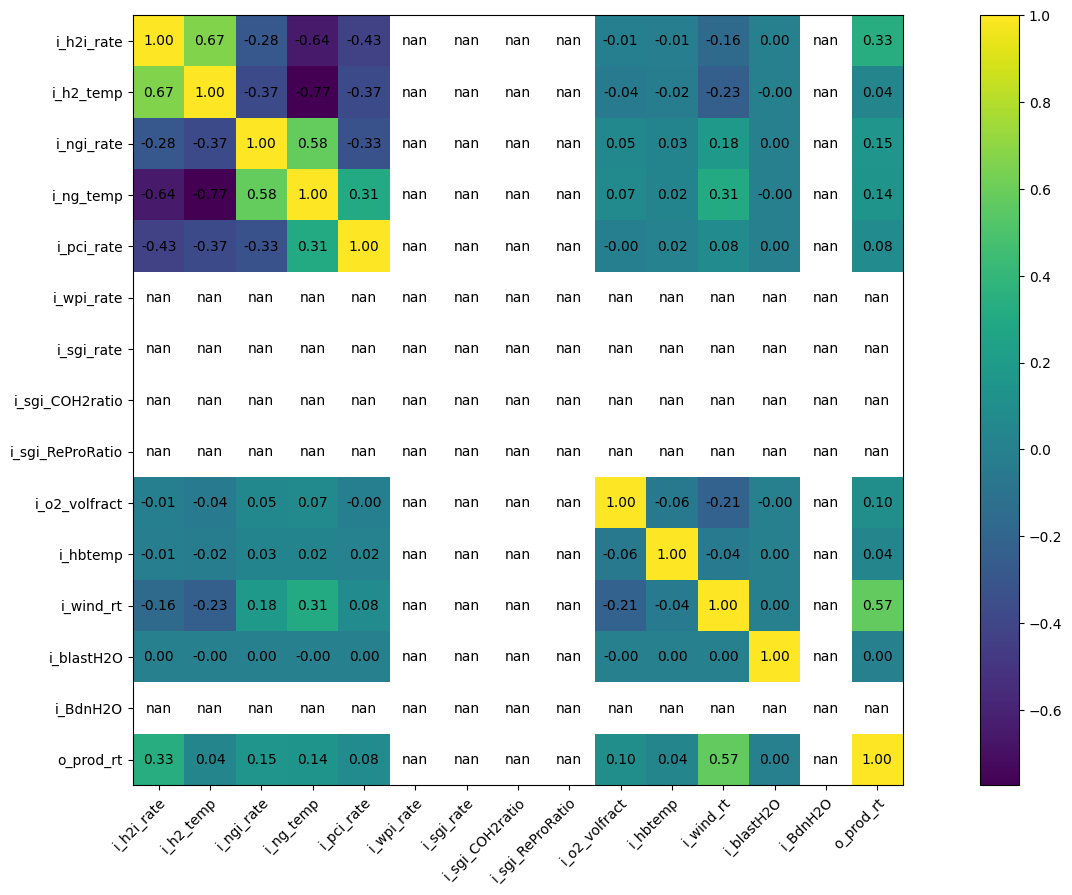

In [14]:

PDFshapingOBJ.list_of_selected_column_names = ['i_h2i_rate','i_h2_temp','i_ngi_rate','i_ng_temp','i_pci_rate',
                    'i_wpi_rate','i_sgi_rate','i_sgi_COH2ratio','i_sgi_ReProRatio','i_o2_volfract',
                    'i_hbtemp','i_wind_rt','i_blastH2O','i_BdnH2O','o_prod_rt']



PDFshapingOBJ.print_correlation_coefficients()


In [15]:

PDFshapingOBJ.convert_pd_data_to_numpy()


[[1 'H2-10_PCI-0_WPI-0_NG-0_O2-30_NGT-0_H2T-1200_HBT-1200_WR-160' 10 ...
  12.3 34.2 6230.0]
 [2 'H2-10_PCI-0_WPI-0_NG-0_O2-30_NGT-0_H2T-600_HBT-1480_WR-160' 10 ...
  12.2 34.1 6250.0]
 [3 'H2-10_PCI-0_WPI-0_NG-0_O2-30_NGT-0_H2T-300_HBT-1600_WR-160' 10 ...
  12.2 34.9 6250.0]
 ...
 [949 'H2-0_PCI-0_WPI-0_NG-120_O2-21_NGT-300_H2T-0_HBT-1200_WR-195' 0 ...
  26.7 63.5 4050.0]
 [950 'H2-0_PCI-0_WPI-0_NG-100_O2-21_NGT-300_H2T-0_HBT-1200_WR-230' 0 ...
  23.3 57.8 4700.0]
 [951 'H2-0_PCI-0_WPI-0_NG-120_O2-21_NGT-300_H2T-0_HBT-1200_WR-230' 0 ...
  26.6 61.8 4610.0]]
(951, 40)



## Select inputs and outputs


In [16]:

PDFshapingOBJ.gen_X_y_for_selected_indeces(  
                   inputs = [ 2, 3, 4, 6, 11, 12, 13 ] , 
                   outputs= [ 19, 21, 23 ]   
)





7
3


In [17]:

print(PDFshapingOBJ.X.shape)
print(PDFshapingOBJ.y.shape)


(951, 7)
(951, 3)


In [18]:

PDFshapingOBJ.random_seed = int( random.random() * 100  )         ## defautl is 42


In [19]:

PDFshapingOBJ.split_np_data_train_test(selected_test_size=0.2)


(760, 7)
(191, 7)
(760, 3)
(191, 3)


In [20]:

PDFshapingOBJ.convert_dataset_from_np_to_torch()


In [21]:

PDFshapingOBJ.standardize_X_scales()
PDFshapingOBJ.standardize_y_scales()


In [22]:

PDFshapingOBJ.gen_Dataloader_train()

PDFshapingOBJ.train_dl


In [23]:

n_inputs  = 7
n_outputs = 3


class SimpleNet(nn.Module):
    def __init__(self, x_means, x_deviations, y_means, y_deviations):
        super().__init__()
        self.x_means      = x_means
        self.x_deviations = x_deviations
        self.y_means      = y_means
        self.y_deviations = y_deviations
        
        self.model = nn.Sequential(
            nn.Linear(n_inputs, 64),
            nn.ReLU(),
            nn.Linear(64, 64),
            nn.ReLU(),
            nn.Linear(64, n_outputs)
        )
        
    def forward(self, x):
        x          = (x - self.x_means) / self.x_deviations
        y_scaled   = self.model(x)
        y_descaled = y_scaled * self.y_deviations + self.y_means
        
        return y_descaled, y_scaled
    
        


In [24]:

model     = SimpleNet(
             PDFshapingOBJ.x_means, 
             PDFshapingOBJ.x_deviations, 
             PDFshapingOBJ.y_means, 
             PDFshapingOBJ.y_deviations
)

optimizer = optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.MSELoss()


In [25]:

model.train()

for epoch in range(1000):
    for xb, yb in PDFshapingOBJ.train_dl:
        optimizer.zero_grad()
        pred_descaled, pred_scaled = model(xb)
        loss = loss_fn(pred_scaled, yb)
        loss.backward()
        optimizer.step()
        if epoch % 50 == 0:
            print( loss.item() ) 
    
    

1.2850265502929688
0.876758337020874
0.7614700794219971
0.6804845929145813
1.268714189529419
0.6713573336601257
0.926279604434967
0.9546471238136292
1.0162535905838013
0.8991897702217102
0.887337863445282
1.238531470298767
0.5819709897041321
1.2264622449874878
0.8672950863838196
0.5775195956230164
0.9860069751739502
0.6142443418502808
1.0990668535232544
0.5451356768608093
0.7809956073760986
0.8943579196929932
0.7152108550071716
0.5678216814994812
0.6989303231239319
0.7364327311515808
1.2599183320999146
0.8757405281066895
1.1651502847671509
0.5678265690803528
0.9277284741401672
0.5903305411338806
0.6705377697944641
0.4906766414642334
0.38413190841674805
0.5964921712875366
0.8216857314109802
0.6219670176506042
0.4840681254863739
0.4382821023464203
0.46999481320381165
0.4075986444950104
0.47533735632896423
0.38521409034729004
0.4095618426799774
0.5731462836265564
1.0552693605422974
0.29129162430763245
0.013857870362699032
0.03630300983786583
0.01972157694399357
0.019983461126685143
0.0224

0.004133434966206551
0.009610021486878395
0.006978166755288839
0.00823714304715395
0.0036785926204174757
0.0029043543618172407
0.008428855799138546
0.011853569187223911
0.003800823353230953
0.003365830285474658
0.01524421852082014
0.003129195189103484
0.0022791989613324404
0.004697848577052355
0.0030969225335866213
0.004370293114334345
0.009809961542487144
0.005941873416304588
0.006887244060635567
0.001870353240519762
0.00372471590526402
0.008239996619522572
0.0037376265972852707
0.005100278649479151
0.004436778835952282
0.0029113925993442535
0.006084506865590811
0.002888438990339637
0.0024607854429632425
0.00496560288593173
0.005839712917804718
0.004288883879780769
0.012233697809278965
0.008097866550087929
0.002886886475607753
0.0041437833569943905
0.004718826152384281
0.0031636536587029696
0.0033902565483003855
0.00911874882876873
0.0035610906779766083
0.0027720630168914795
0.0023005579132586718
0.007272252347320318
0.0032929088920354843
0.0016485569067299366
0.003964511211961508
0.0

0.0029343252535909414
0.002280151005834341
0.002406903775408864
0.0037269240710884333
0.005201186519116163
0.003872852772474289
0.004702914506196976
0.0031966727692633867
0.0035631901118904352
0.002160405507311225
0.003645058488473296
0.005625248420983553
0.0021918565034866333
0.0031133759766817093
0.0025958921760320663
0.004358245059847832
0.003183716908097267
0.001728614210151136
0.0062054782174527645
0.0019844372291117907
0.0029305682983249426
0.0034367069602012634
0.0048737796023488045
0.002230981597676873
0.0026381865609437227
0.004941960331052542
0.0029207421466708183
0.008142584003508091
0.0038474646862596273
0.0016668435418978333
0.0043924893252551556
0.003473360324278474
0.002155519090592861
0.003982542548328638
0.002790553495287895
0.008292551152408123
0.0028124728705734015
0.003024113131687045
0.003996638115495443
0.006503155920654535
0.004722632933408022
0.007347652688622475
0.004151474684476852
0.004643888678401709
0.005741643253713846
0.005181461106985807
0.00247512175701

In [26]:


## an educated guess instead of fully random approach
'''

x0_real = np.array([[10, 300, 5, 150, 0.27, 1200, 700]])  # sample input
## x0_norm = scaler_X.transform(x0_real)
x_guess = torch.tensor(x0_norm, dtype=torch.float32, requires_grad=True)


'''

##############################################


# === 3. Constraint inference: find input x so that output meets target thresholds ===

x_guess = torch.tensor([[20, 600, 10, 250, 0.35, 1300, 900]], requires_grad=True)




optimizer_infer = torch.optim.Adam([x_guess], lr=0.05)

print( x_guess.shape )
print( x_guess ) 


torch.Size([1, 7])
tensor([[   20.0000,   600.0000,    10.0000,   250.0000,     0.3500,  1300.0000,
           900.0000]], requires_grad=True)


In [27]:


'''

desired output requirements
Raceway flame temp > 1900K.....(17, 'o_tuy_temp')
Hot metal temp > 1700K.........(21, 'o_hmt')
Top gas temp > 100C............(23, 'o_tgt')

'''


# Define constraint thresholds
target_output   = torch.tensor([[1900.0, 1700.0, 100.0    ]])  # only 3

target_output   = (target_output - PDFshapingOBJ.y_means) / PDFshapingOBJ.y_deviations

constraint_mask = torch.tensor([  2,     2,      2   ])   # 2 = ≥, 0 = no constraint


In [28]:


def constraint_loss(y_pred, y_target, mask, lower_bounds=None, upper_bounds=None, reg_weight=1e-4):
    loss = 0.0
    for i in range(y_pred.shape[1]):
        if mask[i] == 1:  # equality
            loss = loss + (y_pred[0, i] - y_target[0, i])**2
        elif mask[i] == 2:  # greater than or equal
            loss = loss + torch.relu(y_target[0, i] - y_pred[0, i])**2
        elif mask[i] == 3:  # range constraint
            a = lower_bounds[0, i]
            b = upper_bounds[0, i]
            loss += torch.relu(a - y_pred[0, i])**2
            loss += torch.relu(y_pred[0, i] - b)**2

    # 🛡 Regularization: prevent extreme outputs
    loss += reg_weight * torch.sum(y_pred**2)
    return loss




def constraint_loss2(y_pred, y_target, mask, lower_bounds=None, upper_bounds=None):
    loss = 0.0
    for i in range(y_pred.shape[1]):
        if mask[i] == 1:  # equality
            loss += (y_pred[0, i] - y_target[0, i])**2
        elif mask[i] == 2:  # greater than or equal
            loss += torch.relu(y_target[0, i] - y_pred[0, i])**2
        elif mask[i] == 3:  # range constraint
            a = lower_bounds[0, i]
            b = upper_bounds[0, i]
            loss += torch.relu(a - y_pred[0, i])**2
            loss += torch.relu(y_pred[0, i] - b)**2
    return loss



In [29]:


'''

clamp_max =  torch.tensor([[   0, 250,  0,  50, 0.21, 1100, 600 ]])
clamp_min =  torch.tensor([[  20, 600, 10, 250, 0.35, 1300, 900 ]])
## clamp_max = (clamp_max - PDFshapingOBJ.x_means) / PDFshapingOBJ.x_deviations
## clamp_min = (clamp_min - PDFshapingOBJ.x_means) / PDFshapingOBJ.x_deviations

'''



clamp_min = torch.tensor([[0, 250, 0, 50, 0.21, 1100, 600]])
clamp_max = torch.tensor([[20, 600, 10, 250, 0.35, 1300, 900]])

def soft_box_penalty(x, lower, upper, strength=10.0):
    return strength * ((torch.relu(lower - x) ** 2).sum() + (torch.relu(x - upper) ** 2).sum())





In [30]:

# Run optimization to find x that meets constraints



  
epochs = 200000

for step in range(epochs ):
    optimizer_infer.zero_grad()
    
    y_pred_real, y_pred_scaled = model(x_guess)
    
    loss_main   = constraint_loss(y_pred_scaled, target_output, constraint_mask)
    
    loss_soft   = soft_box_penalty(x_guess, clamp_min, clamp_max)
    
    alpha = 1.0
    loss = alpha * loss_main + (1-alpha) * loss_soft

    loss.backward()
    optimizer_infer.step()
    ## with torch.no_grad():
    ##    if (step / epochs) >= 0.9:
    ##        x_guess[:] = torch.max(x_guess, clamp_max)
    ##        x_guess[:] = torch.min(x_guess, clamp_min)
    if step % 20000 == 0:
        print(x_guess[:])
        print(y_pred_scaled)
        print(target_output)
        print( loss.item() )
        print(  step       )
        print('==================')
        
 

    


tensor([[   19.9500,   599.9500,     9.9500,   250.0500,     0.4000,  1300.0500,
           899.9500]], grad_fn=<SliceBackward0>)
tensor([[  4.9991, -12.7011,  -6.9775]], grad_fn=<AddmmBackward0>)
tensor([[-1.7569,  0.8811,  0.7868]])
244.78466796875
0
tensor([[ -41.1825,  476.1255, -119.3643,  339.9751,   54.9031, 1266.1250,
          795.3242]], grad_fn=<SliceBackward0>)
tensor([[2.4281, 0.8812, 2.7587]], grad_fn=<AddmmBackward0>)
tensor([[-1.7569,  0.8811,  0.7868]])
0.0014282199554145336
20000
tensor([[ -16.3648,  457.2010, -160.8738,  211.4865,   63.4821, 1136.8804,
          766.8076]], grad_fn=<SliceBackward0>)
tensor([[-0.0010,  0.8846,  0.7914]], grad_fn=<AddmmBackward0>)
tensor([[-1.7569,  0.8811,  0.7868]])
0.00014088554598856717
40000
tensor([[ -16.3926,  457.1826, -160.8457,  211.4271,   63.4918, 1136.8583,
          766.7460]], grad_fn=<SliceBackward0>)
tensor([[0.0021, 0.8866, 0.7885]], grad_fn=<AddmmBackward0>)
tensor([[-1.7569,  0.8811,  0.7868]])
0.0001407866511726752

In [31]:


model.eval()
with torch.no_grad():
    final_input     = x_guess.detach().numpy()
    final_output, _ = model(x_guess)
    final_output    = final_output.detach().numpy()

print( final_input.shape )
print( final_output.shape )


(1, 7)
(1, 3)


In [32]:


print("\n🎯 Input that satisfies constraints:")
print("Input:", np.round(final_input, 3))
print("Predicted Output (Temp):", np.round(final_output, 2))



🎯 Input that satisfies constraints:
Input: [[ -16.447  457.079 -160.731  211.017   63.411 1136.867  766.408]]
Predicted Output (Temp): [[2260.27 1700.11  100.05]]


In [33]:

'''


Inputs
(2, 'i_h2i_rate')
(3, 'i_h2_temp')
(4, 'i_ngi_rate')
(6, 'i_pci_rate')
(11, 'i_o2_volfract')
(12, 'i_hbtemp')
(13, 'i_wind_rt')
Outputs
desired output requirements
Raceway flame temp > 1900K.....(19, 'o_fta')
Hot metal temp > 1700K.........(21, 'o_hmt')
Top gas temp > 100C,,,,,,,,,,,.(23, 'o_tgt')




'''


"\n\n\nInputs\n(2, 'i_h2i_rate')\n(3, 'i_h2_temp')\n(4, 'i_ngi_rate')\n(6, 'i_pci_rate')\n(11, 'i_o2_volfract')\n(12, 'i_hbtemp')\n(13, 'i_wind_rt')\nOutputs\ndesired output requirements\nRaceway flame temp > 1900K.....(19, 'o_fta')\nHot metal temp > 1700K.........(21, 'o_hmt')\nTop gas temp > 100C,,,,,,,,,,,.(23, 'o_tgt')\n\n\n\n\n"


## other
